In [1]:
import os
os.chdir("../")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import ee
ee.Initialize()
import geemap
print(ee.__version__)

0.1.360


In [2]:
dc = ee.FeatureCollection('TIGER/2018/States').filterMetadata('NAME', 'equals', 'District of Columbia').geometry()

## VIIRS

In [3]:
viirs = (ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG")
                .select('avg_rad')
                .filterDate('2014-01-01','2023-06-01'))
print(f"there are {viirs.size().getInfo()} images in this collection.")

there are 111 images in this collection.


In [4]:
def ee_array_to_df(arr, list_of_bands):
    df = pd.DataFrame(arr)

    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)
    df = df[['longitude', 'latitude', 'time', *list_of_bands]].dropna()

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')

    # Convert the time field into a datetime.
    df['datetime'] = pd.to_datetime(df['time'], unit="ms")
    return df

In [5]:
scale = 1000
dc_ntl = viirs.getRegion(dc, scale).getInfo()
dc_ntl_df = ee_array_to_df(dc_ntl, ["avg_rad"])
dc_ntl_df.head(5)

,longitude,latitude,time,avg_rad,datetime
0,-77.035027,38.802729,1388534400000,14.910999,2014-01-01
1,-77.035027,38.802729,1391212800000,12.099113,2014-02-01
2,-77.035027,38.802729,1393632000000,16.276340,2014-03-01
3,-77.035027,38.802729,1396310400000,12.295531,2014-04-01
4,-77.035027,38.802729,1398902400000,12.905051,2014-05-01


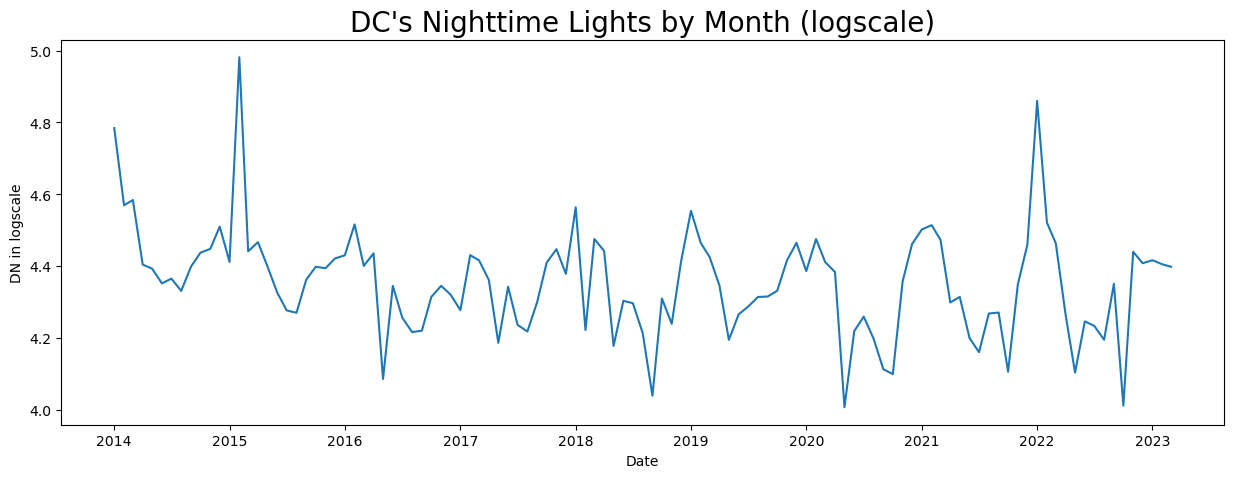

In [6]:
ntl_df_ts = dc_ntl_df[["datetime", "avg_rad"]].groupby(by="datetime").mean().reset_index()
ntl_df_ts["avg_rad_log"] = np.log(ntl_df_ts["avg_rad"])

fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(x="datetime", y="avg_rad_log", data=ntl_df_ts, ax=ax)
plt.xlabel("Date")
plt.ylabel("DN in logscale")
plt.title("DC's Nighttime Lights by Month (logscale)", fontsize=20);

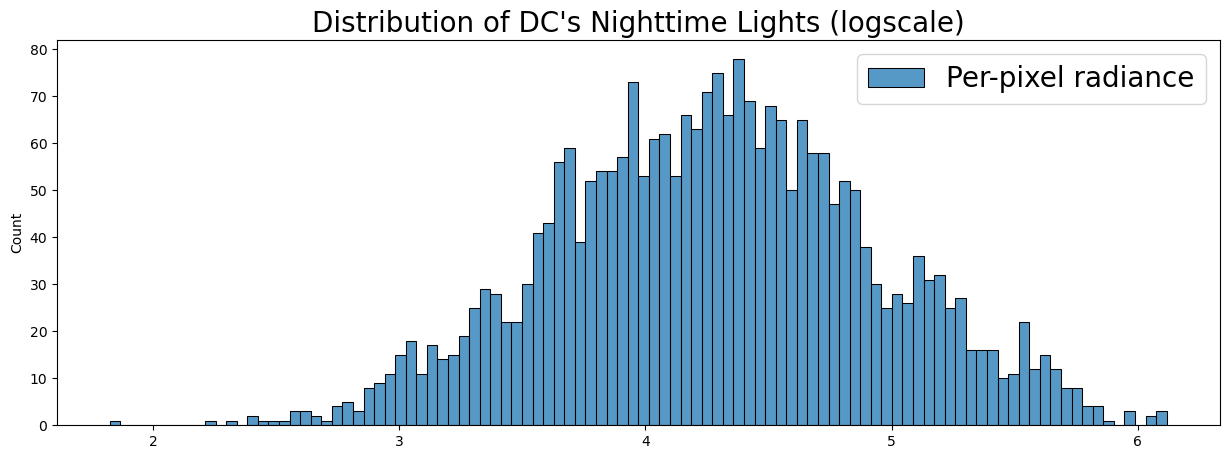

In [7]:
arr = np.array(viirs.first().sampleRectangle(region=dc).get('avg_rad').getInfo())
data = np.log(arr.flatten())

fig, ax = plt.subplots(figsize=(15, 5))
sns.histplot(data, bins=100, label="Per-pixel radiance", legend=True, ax=ax)
plt.legend(fontsize=20)
plt.title("Distribution of DC's Nighttime Lights (logscale)", fontsize=20);

In [8]:
dcMap = geemap.Map()
dcMap.centerObject(dc, zoom=12)
dcMap.add_basemap('CartoDB.DarkMatter')
viirsmed = viirs.median()
dcMap.addLayer(viirsmed.mask(viirsmed).clip(dc), {'min':1,'max':20}, opacity=0.6)
dcMap

Map(center=[38.90475739114548, -77.01628733224862], controls=(WidgetControl(options=['position', 'transparent_…